In [2]:
from defenses.base.loader import get_loader
from defenses.base.model import get_model
from defenses.adv_fgsm.train import Trainer, get_acc

Loader : Base
Model : Base
Train : Adv FSGM


In [3]:
import torch
import torchattacks
from torchattacks import FGSM, PGD, MultiAttack
torch.cuda.set_device(1)

In [22]:
_, test_loader = get_loader()

model = get_model().cuda()
model.load_state_dict(torch.load("./_models/04_Fast_C/025.pth"))
model = model.cuda().eval()

Files already downloaded and verified
Files already downloaded and verified
Data Loaded!
Train Data Length : 50000
Test Data Length : 10000
WRN-28 is loaded.


## 3. White Box Attack

In [23]:
print("Final Test Acc : %2.2f"%get_acc(model, test_loader))

Final Test Acc : 79.75


### 3.1 FGSM

In [24]:
fgsm = FGSM(model, eps=8/255)
fgsm.set_mode('int')
fgsm.save(data_loader=test_loader,
          file_name="_temp.pt", accuracy=True)

- Save Progress : 100.00 % / Accuracy : 47.75 %
- Save Complete!


### 3.2 PGD

In [25]:
# WB2 : PGD
pgd = PGD(model, alpha=2/255, eps=8/255, iters=50)
pgd.set_mode('int')
pgd.save(data_loader=test_loader,
         file_name="_temp.pt", accuracy=True)

- Save Progress : 100.00 % / Accuracy : 39.17 %
- Save Complete!


### 3.3 PGD with 10 Random Restarts

In [26]:
# WB3 : PGD
pgd = PGD(model, alpha=2/255, eps=8/255, iters=50, random_start=True)
multi = MultiAttack(model, [pgd]*10)
multi.set_mode('int')
multi.save(data_loader=test_loader,
           file_name="_temp.pt", accuracy=True)

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 1; 11.75 GiB total capacity; 6.13 GiB already allocated; 2.75 MiB free; 6.24 GiB reserved in total by PyTorch)

## 4. Black Box Attack

In [17]:
from torch.utils.data import TensorDataset, DataLoader

In [30]:
# BB1 : WRN_28_20
adv_images, adv_labels = torch.load("./_datasets/00_WRN_28_20_PGD.pt")
adv_data = TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
get_acc(model, adv_loader)

78.23

In [29]:
# BB2 : WRN_40_10
adv_images, adv_labels = torch.load("./_datasets/00_WRN_40_10_PGD.pt")
adv_data = torch.utils.data.TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
get_acc(model, adv_loader)

78.31

## 5. Brendel & Bethge

In [14]:
import foolbox as fb
import time
fmodel = fb.PyTorchModel(model,bounds=(0,1),device='cuda')

In [16]:
_, test_loader = get_loader(batch_size=20)

test_iter = iter(test_loader)
new_test = []
for i in range(50) :
    new_test.append(test_iter.next())

Files already downloaded and verified
Files already downloaded and verified
Data Loaded!
Train Data Length : 50000
Test Data Length : 10000


In [18]:
def new_attack(images, labels) :
    
    images, labels = images.cuda(), labels.cuda()

    batches = [(images[:10], labels[:10]), (images[10:], labels[10:])]

    init_attack = fb.attacks.DatasetAttack()
    init_attack.feed(model=fmodel, inputs=batches[0][0])   # feed 1st batch of inputs
    init_attack.feed(model=fmodel, inputs=batches[1][0])   # feed 2nd batch of inputs

    criterion = fb.Misclassification(labels)

    init_advs = init_attack.run(fmodel, images, criterion)

    attack = fb.attacks.L2BrendelBethgeAttack(init_attack=init_attack)

    advs = attack.run(fmodel, images.cuda(),
                      labels.cuda(), starting_points=init_advs)
    return advs

def save(model, attack, data_loader, file_name, accuracy=True, device='cuda'):

    model.eval()

    image_list = []
    label_list = []

    correct = 0
    total = 0

    total_batch = len(data_loader)

    for step, (images, labels) in enumerate(data_loader) :
        adv_images = attack(images, labels)

        image_list.append(adv_images.cpu())
        label_list.append(labels.cpu())

        if accuracy :
            outputs = model(adv_images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(torch.device(device))).sum()

        print('- Save Progress : %2.2f %%        ' %((step+1)/total_batch*100), end='\r')

    if accuracy :
        acc = 100 * float(correct) / total
        print('\n- Accuracy of the model : %2.2f %%' % (acc), end='')

    x = torch.cat(image_list, 0)
    y = torch.cat(label_list, 0)
    torch.save((x, y), file_name)
    print('\n- Save Complete!')
    
    return image_list

In [19]:
st = time.time()
adv_list = save(model, new_attack, new_test, '_temp.pt')
print(time.time()-st)

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/brendel_bethge.py:621: UserWarning:

At the first initialisation the optimizer needs to be compiled. This may take between 20 to 60 seconds.



- Save Progress : 100.00 %        
- Accuracy of the model : 0.00 %
- Save Complete!
2850.632907152176


In [28]:
from torchhk.vis import *

- Stats
Max : 9.902379
Min : 0.000000
Mean : 0.950218
Median : 0.646695


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



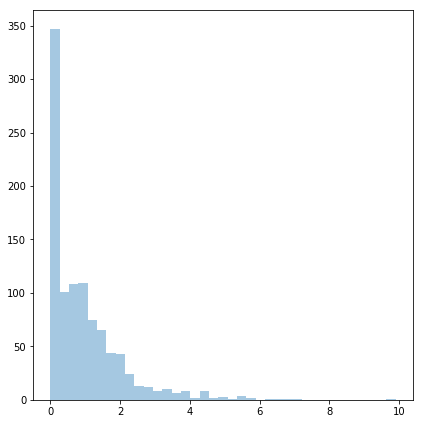

In [33]:
test_images = torch.cat([i[0] for i in new_test])
test_labels = torch.cat([i[1] for i in new_test])
adv_images = torch.cat(adv_list)
l2 = (((adv_images-test_images)**2).reshape(len(adv_images),-1).sum(1)).sqrt()
ax = init_plot()
plot_dist(ax, l2)

In [51]:
from torch.utils.data import DataLoader, TensorDataset
# adv_images, adv_labels = torch.load("./"+'VGG_Nonbayes_Adv_BB_L2.pt')

acc = []
for i in range(0, 10) :
    in_mask = torch.masked_select(torch.arange(len(l2)), l2 <= i)
    out_mask = torch.masked_select(torch.arange(len(l2)), l2 > i)
    new_images = test_images.clone().detach()
    new_images[in_mask] = adv_images[in_mask]
    
    adv_data = TensorDataset(new_images, test_labels)
    adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
    
    acc.append(get_acc(model, adv_loader))
    
ax = init_plot(xlim=(-0.5, 10), ylim=(0, 100))
plot_line(ax, x=torch.arange(10), input=acc)

## Accuracy/Epsilon Graph

## Loss Surface

## Show Image